In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Tweet Classification") \
    .getOrCreate()


In [2]:
# Load data
df1 = spark.read.csv("twitter_data.csv", header=True, inferSchema=True)
df2 = spark.read.csv("train.csv", header=True, inferSchema=True)
df2

DataFrame[id: int, label: int, tweet: string]

In [3]:
df2=df2.select("tweet", "label").withColumnRenamed("tweet", "class")
df1=df1.select("tweet","class")


In [4]:
tweet_df = df1.union(df2)
tweet_df.show()

+--------------------+-----+
|               tweet|class|
+--------------------+-----+
|!!! RT @mayasolov...|    2|
|!!!!! RT @mleew17...|    1|
|!!!!!!! RT @UrKin...|    1|
|!!!!!!!!! RT @C_G...|    1|
|!!!!!!!!!!!!! RT ...|    1|
|"!!!!!!!!!!!!!!!!...|    1|
|"!!!!!!""@__Brigh...|    1|
|!!!!&#8220;@selfi...|    1|
|""" &amp; you mig...|    1|
|""" @rhythmixx_ :...|    1|
|                NULL| NULL|
|""" Keeks is a bi...|    1|
|""" Murda Gang bi...|    1|
|""" So hoes that ...|    1|
|""" bad bitches i...|    1|
|""" bitch get up ...|    1|
|""" bitch nigga m...|    1|
|""" bitch plz wha...|    1|
|""" bitch who do ...|    1|
|""" bitches get c...|    1|
+--------------------+-----+
only showing top 20 rows



In [5]:
data_to_add = [
    ["i hate you", 1],
    ["i kill you", 1],
    ["She felt an overwhelming sense of love whenever she looked into her child's eyes.", 0],
    ["Their love for each other grew stronger with every passing day.", 0],
    ["Love knows no boundaries, transcending differences of race, religion, or background.", 0],
    ["The couple's love story is one of resilience and unwavering commitment through life's challenges.", 0],
    ["He expressed his love through small, thoughtful gestures that made her heart flutter.", 0],
    ["Love is the cornerstone of their enduring friendship that has lasted for decades.", 0],
    ["The warmth in their embraces conveyed a love that words couldn't fully capture.", 0],
    ["Love can be found in the simplest moments, like sharing laughter over a cup of coffee.", 0],
    ["Their love for nature led them to explore the world together, cherishing every adventure.", 0],
    ["Love has the power to heal, to inspire, and to bring out the best in people.", 0],
    ["Enjoying a lazy Sunday with a good book and a cup of coffee. #RelaxationTime #Bookworm", 0],
    ["Had an inspiring conversation with a mentor today. Grateful for their guidance and wisdom. #Gratitude #Mentorship", 0],
    ["I despise everything about this place!", 1],
    ["I can't stand this situation anymore.", 1],
    ["Her smile lights up the whole room.", 0],
    ["They found love in the most unexpected place.", 0],
    ["This is the worst day ever. I feel completely destroyed.", 1],
    ["Their bond was stronger than ever, rooted in mutual trust and respect.", 0],
    ["Love is about patience, understanding, and forgiveness.", 0],
    ["I just want to scream out of frustration!", 1],
    ["He showed kindness when no one else did.", 0],
    ["They stood by each other in times of joy and hardship.", 0],
    ["My anger is boiling over. I can't take this anymore!", 1],
    ["They celebrated their love with close family and friends.", 0],
    ["This situation makes me want to tear everything apart!", 1],
    ["She had never felt so loved and appreciated.", 0],
    ["I absolutely hate how things have turned out.", 1],
    ["The love between them was unbreakable, even after years.", 0],
    ["He couldn't hide the rage he felt inside.", 1],
    ["Feeling truly blessed and grateful for the people in my life.", 0],
    ["The depth of their connection was truly remarkable.", 0],
    ["He let his anger control him, and it destroyed everything.", 1],
    ["The warmth of their love was evident in every word they shared.", 0],
    ["I feel trapped and suffocated by all this negativity.", 1],
    ["Their love story was one for the ages, filled with passion and joy.", 0],
    ["My frustration is beyond anything I've ever felt before.", 1],
    ["They knew their love was the only thing that could get them through tough times.", 0],
    ["I can't deal with this madness anymore.", 1],
    ["He felt a surge of affection every time he saw her.", 0],
    ["This is a nightmare, I wish I could just disappear!", 1],
    ["Their love was like a beacon, guiding them through life's challenges.", 0],
    ["I am utterly furious with the way things are going.", 1],
    ["They shared a deep love for music, which brought them even closer.", 0],
    ["I hate how helpless I feel in this situation.", 1],
    ["Every moment spent together strengthened their love.", 0],
    ["I am beyond angry and frustrated!", 1],
    ["Their love was undeniable, written in the way they looked at each other.", 0],
    ["Nothing makes me more angry than being ignored.", 1],
    ["The love they shared was pure and unconditional.", 0],
    ["I can't believe how mad I am right now.", 1],
    ["They expressed their love through little acts of kindness.", 0],
    ["This has been the worst day of my life, full of rage.", 1],
    ["Their love transcended the distance that separated them.", 0],
    ["I can't stand how things are right now.", 1],
    ["Love is what binds us together, even when we're far apart.", 0],
    ["I hate everything about this!", 1],
    ["Their love was the one constant in an ever-changing world.", 0],
    ["I am so angry, I feel like I'm going to explode.", 1],
    ["They cherished the simple things in life, like long walks and deep conversations.", 0],
    ["I'm furious, I can't believe what just happened.", 1],
    ["Love has a way of healing even the deepest wounds.", 0],
    ["I hate when things don't go my way.", 1],
    ["Their love grew stronger as they faced life's challenges together.", 0],
    ["I'm so mad, I just want to break something.", 1],
    ["Love is what gives life meaning, no matter how hard things get.", 0],
    ["I hate the way things have turned out!", 1],
    ["Their love was the one thing that kept them going through tough times.", 0],
    ["I'm furious, this is unacceptable!", 1],
    ["Their love for each other was evident in every smile, every touch.", 0],
    ["I can't stand this situation, I'm so angry!", 1],
    ["Their love was a beautiful dance, full of joy and tenderness.", 0],
    ["I feel rage like never before, I can't handle this!", 1],
    ["Their love shone brighter with each passing day.", 0],
    ["I hate everything about this day!", 1],
    ["Their love for art brought them together in unexpected ways.", 0],
    ["I can't believe how angry I am right now.", 1],
    ["Love has the power to change everything.", 0],
    ["I'm so mad, I can't think straight.", 1],
    ["Their love story was one of hope, resilience, and joy.", 0],
    ["I hate how this has turned out.", 1],
    ["Their love grew even stronger despite the challenges they faced.", 0],
    ["I'm beyond angry, I feel like I'm going to explode.", 1],
    ["Their love was the light that guided them through the darkest times.", 0],
    ["I'm furious, I can't handle this situation any longer.", 1],
    ["Their love brought out the best in each other.", 0],
    ["I'm so angry, I can't focus on anything else.", 1],
    ["Their love was a testament to the power of patience and understanding.", 0],
    ["I hate everything about this situation!", 1],
    ["Their love story was one for the ages, full of passion and joy.", 0],
    ["I'm furious, I don't know how to handle this rage.", 1],
    ["Their love for life was contagious, spreading to everyone around them.", 0],
     ["Every sunrise reminds me of the love that fills my heart.", 0],
    ["Her laughter is the sweetest melody I've ever heard.", 0],
    ["He has a heart of gold, always helping those in need.", 0],
    ["Love is the greatest adventure I’ve ever embarked on.", 0],
    ["Finding joy in the little things makes life beautiful.", 0],
    ["Their friendship is built on trust and mutual respect.", 0],
    ["The support of my friends makes me feel invincible.", 0],
    ["The way he cares for others inspires me every day.", 0],
    ["Watching children play fills my heart with happiness.", 0],
    ["The kindness of strangers can change a day for the better.", 0],
    ["Sharing stories over coffee brings people closer together.", 0],
    ["Nature’s beauty reminds me of the love in our lives.", 0],
    ["The bond between siblings is unbreakable.", 0],
    ["Helping others brings a sense of fulfillment.", 0],
    ["Every moment spent with loved ones is a treasure.", 0],
    ["The feeling of home is found in the hearts we cherish.", 0],
    ["Little acts of kindness can create a ripple of joy.", 0],
    ["The love I feel for my pets is unconditional.", 0],
    ["Creating memories with family is what life is all about.", 0],
    ["A good book can be a companion on a lonely day.", 0],
    ["Celebrating small victories with friends is what makes life sweet.", 0],
    ["The joy of cooking a meal for loved ones warms my heart.", 0],
    ["Flowers blooming in spring symbolize hope and love.", 0],
    ["The first sip of coffee in the morning brings comfort.", 0],
    ["Laughter shared with friends is the best medicine.", 0],
    ["Helping a neighbor brings the community together.", 0],
    ["The beauty of a sunset reminds me of life’s simple pleasures.", 0],
    ["Being surrounded by family is a blessing.", 0],
    ["Friendship is the foundation of a happy life.", 0],
    ["A handwritten note can brighten someone’s day.", 0],
    ["The joy of giving gifts comes from the heart.", 0],
    ["Every hug from a friend feels like a warm blanket.", 0],
    ["Listening to music can transport you to a happier place.", 0],
    ["Sharing dreams with friends is a magical experience.", 0],
    ["The smell of fresh flowers can uplift the spirit.", 0],
    ["Visiting a new place with friends creates unforgettable memories.", 0],
    ["The love of a grandparent is like no other.", 0],
    ["A family game night brings everyone closer.", 0],
    ["Watching the stars at night fills me with wonder.", 0],
    ["The taste of homemade cookies brings back childhood memories.", 0],
    ["A warm cup of tea can soothe the soul.", 0],
    ["Volunteering makes me appreciate what I have even more.", 0],
    ["A good conversation can change your perspective.", 0],
    ["The joy of a surprise visit from a friend is irreplaceable.", 0],
    ["Exploring nature brings peace to my heart.", 0],
    ["Art has a way of expressing emotions that words cannot.", 0],
    ["A day spent at the beach is a day well spent.", 0],
    ["Happiness is found in the company of good friends.", 0],
    ["A simple smile can brighten anyone’s day.", 0],
    ["Creating art is a beautiful way to express love.", 0],
    ["Finding love in unexpected places is magical.", 0],
    ["The laughter of children is music to my ears.", 0],
    ["A peaceful walk in the park can clear the mind.", 0],
    ["Reading a great book can be an escape from reality.", 0],
    ["A warm fireplace makes for cozy family gatherings.", 0],
    ["Gardening brings joy and beauty to my life.", 0],
    ["Each season brings its own unique beauty.", 0],
    ["A love letter can make someone's heart flutter.", 0],
    ["The sound of rain is calming and refreshing.", 0],
    ["Every shared meal strengthens bonds of love.", 0],
    ["The smell of baked bread is comforting and inviting.", 0],
    ["Going for a hike can refresh the soul.", 0],
    ["Every day is a new chance to spread kindness.", 0],
    ["Finding a lost item can bring immense joy.", 0],
    ["The taste of fresh fruit is a reminder of nature’s gifts.", 0],
    ["A family picnic can create beautiful memories.", 0],
    ["Every pet deserves love and care.", 0],
    ["Connecting with old friends can reignite joy.", 0],
    ["A home-cooked meal is made with love.", 0],
    ["Love is about being there for each other, no matter what.", 0],
    ["Cherishing the small moments leads to a joyful life.", 0],
    ["The beauty of a rainbow brings hope after the rain.", 0],
    ["Appreciating art brings culture into our lives.", 0],
    ["Every compliment has the power to lift someone’s spirits.", 0],
    ["A new experience can spark joy and excitement.", 0],
    ["The comfort of a blanket on a cold day is priceless.", 0],
    ["Helping someone in need brings a sense of fulfillment.", 0],
    ["A shared secret can strengthen a friendship.", 0],
    ["The taste of chocolate can make any day better.", 0],
    ["The beauty of a clear blue sky is refreshing.", 0],
    ["Creating a scrapbook preserves beautiful memories.", 0],
    ["The joy of travel brings new perspectives.", 0],
    ["The love of a good friend can get you through tough times.", 0],
    ["Finding joy in hobbies can enhance happiness.", 0],
    ["Each day is a new opportunity to make a difference.", 0],
    ["A family reunion brings joy and laughter.", 0],
    ["A heartfelt compliment can make someone's day.", 0],
    ["Every laugh shared is a moment to cherish.", 0],
    ["The power of a hug can heal many wounds.", 0],
    ["Every memory made with loved ones is a gift.", 0],
    ["The feeling of sand between your toes is liberating.", 0],
    ["The beauty of a flower can brighten any day.", 0],
    ["Creating new traditions can enhance family bonds.", 0],
    ["The act of kindness can spread like wildfire.", 0],
    ["Finding a new passion can spark joy.", 0],
    ["The support of a friend can make all the difference.", 0],
    ["Every sunset brings a promise of a new dawn.", 0],
    ["Finding peace in solitude can be a beautiful experience.", 0],
    ["Her voice was like a melody that always brought peace to his heart.", 0],
    ["The love in their family was the strongest bond they shared.", 0],
    ["Every day with her feels like a blessing beyond measure.", 0],
    ["A day spent with loved ones is a day well lived.", 0],
    ["Her gentle touch had the power to soothe all his worries.", 0],
    ["The love in their home was the foundation of their happiness.", 0],
    ["Her smile had the ability to brighten even the darkest days.", 0],
    ["They found joy in each other's company, no matter what life threw at them.", 0],
    ["Spending time with my family always fills my heart with joy.", 0],
    ["Their love was as constant and beautiful as the ocean waves.", 0],
    ["Sharing stories with friends brings warmth to my soul.", 0],
    ["Their love grew stronger with every memory they made together.", 0],
    ["The happiness in their eyes was a reflection of the love in their hearts.", 0],
    ["Every gesture, no matter how small, was filled with love.", 0],
    ["The sound of children laughing is a reminder of pure joy.", 0],
    ["He loved her not for her beauty, but for the kindness in her heart.", 0],
    ["Their love is what keeps me believing in magic.", 0],
    ["The warmth of their relationship could be felt by everyone around them.", 0],
    ["Their relationship was a true partnership, based on mutual respect and love.", 0],
    ["He always made her feel like she was the most important person in the world.", 0],
    ["The love that filled their home was a testament to their unity.", 0],
    ["Their love created a safe haven, no matter where they were.", 0],
    ["Sharing a meal with loved ones always makes life sweeter.", 0],
    ["He found peace in her embrace, and nothing else mattered.", 0],
    ["Their love was like a gentle breeze, soft and comforting.", 0],
    ["Every kind word they exchanged was a building block in their strong relationship.", 0],
    ["She felt truly loved and supported by the people in her life.", 0],
    ["They found joy in life’s simple pleasures, like a walk at sunset.", 0],
    ["Every challenge they faced only brought them closer together.", 0],
    ["Their love story was written in the stars, meant to be.", 0],
    ["The joy they shared was contagious, spreading to everyone around them.", 0],
    ["The strength of their love carried them through every obstacle.", 0],
    ["Her laugh was infectious, making everyone around her smile.", 0],
    ["Their bond was so strong that they could communicate without words.", 0],
    ["No matter how far apart they were, their love remained constant.", 0],
    ["Her compassion for others was one of the things he loved most about her.", 0],
    ["They spent their lives building a love that would last forever.", 0],
    ["Their love shone through in every little thing they did for each other.", 0],
    ["He found joy in every moment he spent with her.", 0],
    ["Their love was like a garden, nurtured with care and attention.", 0],
    ["Her love was like a beacon, guiding him through tough times.", 0],
    ["The love they shared was the best part of their lives.", 0],
    ["Even the little things they did together were filled with love and joy.", 0],
    ["Their love was like a beautiful song that played in their hearts every day.", 0],
    ["The love they had for their children was boundless and unconditional.", 0],
    ["Her love gave him the strength to face any challenge.", 0],
    ["Every time he looked at her, he fell in love all over again.", 0],
    ["Their love was a gift that they never took for granted.", 0],
    ["Her love for life was infectious, inspiring everyone around her.", 0],
    ["His heart overflowed with love every time he thought of her.", 0],
    ["Their love was like a lighthouse, always guiding them home.", 0],
    ["Every day spent together was a new adventure filled with love.", 0],
    ["They loved each other so deeply that nothing could come between them.", 0],
    ["Her love for him was as strong as it had been the day they met.", 0],
    ["The love between them grew stronger with every passing year.", 0],
    ["She found joy in every moment she spent with the people she loved.", 0],
    ["Their love was like the sun, always shining brightly even on cloudy days.", 0],
    ["He was always there for her, loving and supporting her no matter what.", 0],
    ["Their love was the foundation of everything they built together.", 0],
    ["His love for her was unconditional, constant, and unwavering.", 0],
    ["They loved each other through every trial, and it only made them stronger.", 0],
    ["Her love was like a river, steady and ever-flowing.", 0],
    ["They found joy in the simplest moments, just being together.", 0],
    ["Her love gave him the courage to chase his dreams.", 0],
    ["Their love was like a garden in full bloom, vibrant and beautiful.", 0],
    ["The love in their family was the greatest gift of all.", 0],
    ["They found peace and joy in each other's company.", 0],
    ["The love they shared was built on a foundation of trust and respect.", 0],
    ["She was his rock, always loving and supporting him.", 0],
    ["Every day with her was filled with laughter and love.", 0],
    ["Their love was as strong as the day they first met.", 0],
    ["Her love for him was evident in everything she did.", 0],
    ["Their love was a source of strength and comfort.", 0],
    ["They were truly happy because their lives were filled with love.", 0],
    ["He loved her with all his heart, and she loved him just as much.", 0],
    ["Their love story was one for the ages, filled with joy and laughter.", 0],
    ["Her love made him feel like he could conquer the world.", 0],
    ["Their love was a beautiful dance, full of grace and harmony.", 0],
    ["She found happiness in making others smile.", 0],
    ["Their love was a masterpiece, painted with the colors of their lives.", 0],
    ["They loved each other more with every passing day.", 0],
    ["Her love was the light in his darkest days.", 0],
    ["Their love for each other was pure and beautiful.", 0],
    ["The love they shared was like a warm blanket on a cold day.", 0],
    ["Their love was the greatest adventure of their lives.", 0],
    ["She felt blessed to be surrounded by so much love.", 0],
    ["Their love was the one constant in an ever-changing world.", 0],
    ["His love for her was as steady as the stars in the sky.", 0],
    ["The love in their hearts was reflected in everything they did.", 0],
    ["Her love made everything in life feel more meaningful.", 0],
    ["The love they shared was stronger than any challenge they faced.", 0],
    ["They built a life filled with love, laughter, and happiness.", 0],
    ["Her love for life was contagious, and it made everyone around her happy.", 0],
    ["They loved each other so much that their happiness was intertwined.", 0],
    ["Her love gave him hope for a brighter tomorrow.", 0],
    ["Their love was like a fire, always burning bright and warm.", 0]
]
# Create a new DataFrame from the new data
new_data_df = spark.createDataFrame(data_to_add, ["tweet", "class"])

# Concatenate the existing DataFrame with the new DataFrame
tweet_df = tweet_df.union(new_data_df)

In [6]:
import re
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# Define the data processing function with NoneType handling
def data_processing(tweet):
    if tweet is None:  # Check for NoneType values
        return ""
    tweet = tweet.lower()
    tweet = re.sub(r"https?\S+|www\S+|http\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r'ð', '', tweet)
    tweet = tweet.replace("user", "")
    return tweet

# Register the function as a UDF
data_processing_udf = F.udf(data_processing, StringType())

# Apply the UDF to the 'tweet' column
tweet_df = tweet_df.withColumn('tweet', data_processing_udf(F.col('tweet')))

# Display the result
tweet_df.show(truncate=False)


Py4JJavaError: An error occurred while calling o89.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 5.0 failed 1 times, most recent failure: Lost task 0.0 in stage 5.0 (TID 5) (PRADEEP executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:54)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.UnionRDD.compute(UnionRDD.scala:108)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:699)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:743)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:690)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:655)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:631)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:588)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:546)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 30 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4334)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4324)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4322)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4322)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3539)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:54)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.UnionRDD.compute(UnionRDD.scala:108)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:699)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:743)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:690)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:655)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:631)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:588)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:546)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 30 more


In [7]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# Download the necessary resources (run this only once)
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the lemmatizing function
def lemmatizing(data):
    if data is None:  # Handle None values
        return ""
    tweet = [lemmatizer.lemmatize(word) for word in word_tokenize(data)]
    return " ".join(tweet)

# Register the function as a UDF
lemmatizing_udf = F.udf(lemmatizing, StringType())

# Apply the UDF to the 'tweet' column
tweet_df = tweet_df.withColumn('tweet', lemmatizing_udf(F.col('tweet')))

# Show the result
tweet_df.show(truncate=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


+----------------------------------------------------------------------------------------------------------------+-----+
|tweet                                                                                                           |class|
+----------------------------------------------------------------------------------------------------------------+-----+
|rt a a woman you shouldnt complain about cleaning up your house amp a a man you should always take the trash out|2    |
|rt boy dat coldtyga dwn bad for cuffin dat hoe in the 1st place                                                 |1    |
|rt dawg rt you ever fuck a bitch and she start to cry you be confused a shit                                    |1    |
|rt she look like a tranny                                                                                       |1    |
|rt the shit you hear about me might be true or it might be faker than the bitch who told it to ya 57361         |1    |
|the shit just blow meclaim you 

In [8]:
# Drop duplicates based on the 'tweet' column
tweet_df = tweet_df.dropDuplicates(['tweet'])
tweet_df = tweet_df.na.drop(subset=["class"])
# Show the result
tweet_df.show(truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------+-----+
|tweet                                                                                                                                   |class|
+----------------------------------------------------------------------------------------------------------------------------------------+-----+
|cant worry about a bitch that aint worried bout me real                                                                                 |1    |
|tim tebow got cut from every team he wa on in the nfl and he already got more hoe than me in starkville smh 128514128514128514128514    |1    |
|fit lad nice gear these scally lad n trainer would get it                                                                               |2    |
|dont let your side bitch settle in                                                                                               

In [9]:
from pyspark.sql.functions import when, col
tweet_df = tweet_df.withColumn("class", when(col("class") == 2, 0).otherwise(col("class")))


In [10]:
# Get the count of unique values in the 'class' column
class1_counts = tweet_df.groupBy('class').count()
# Show the result
class1_counts.show()


+-----+-----+
|class|count|
+-----+-----+
|    0|32315|
|    1|20711|
+-----+-----+



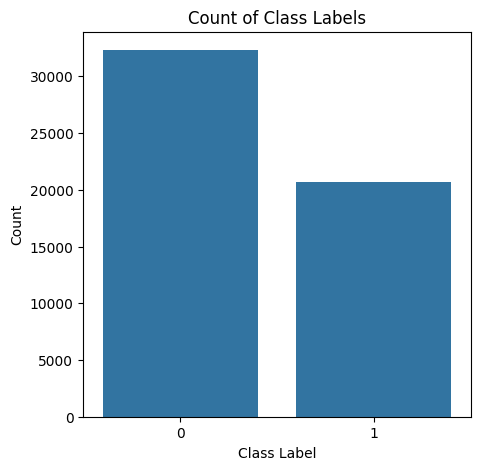

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
tweet_df_pd = tweet_df.toPandas()
# Create the count plot
plt.figure(figsize=(5, 5))
sns.countplot(x='class', data=tweet_df_pd)
# Set plot title and labels
plt.title('Count of Class Labels')
plt.xlabel('Class Label')
plt.ylabel('Count')

# Show the plot
plt.show()

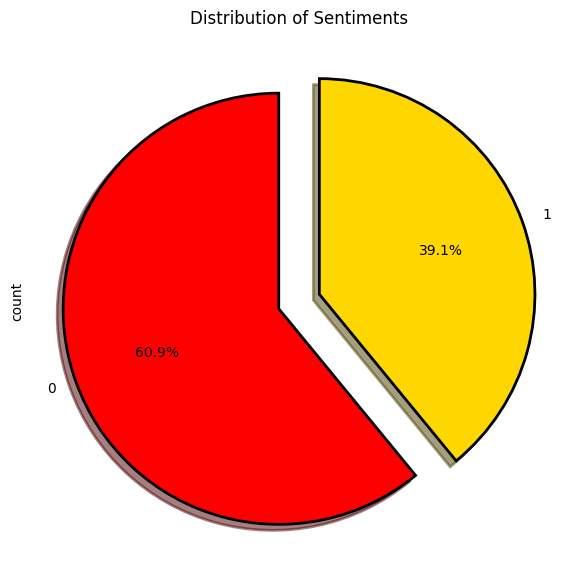

In [12]:
# Create a pie chart
fig = plt.figure(figsize=(7, 7))
colors = ("red", "gold")
wp = {'linewidth': 2, 'edgecolor': "black"}

# Calculate the distribution of class1
tags = tweet_df_pd['class'].value_counts()

# Create explode effect
explode = [0.1] * len(tags)

# Plotting the pie chart
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors, startangle=90,
          wedgeprops=wp, explode=explode, labels=tags.index)

# Set title
plt.title('Distribution of Sentiments')

# Show the plot
plt.show()

In [13]:
non_hate_tweets = tweet_df.filter(tweet_df["class"] == 0)

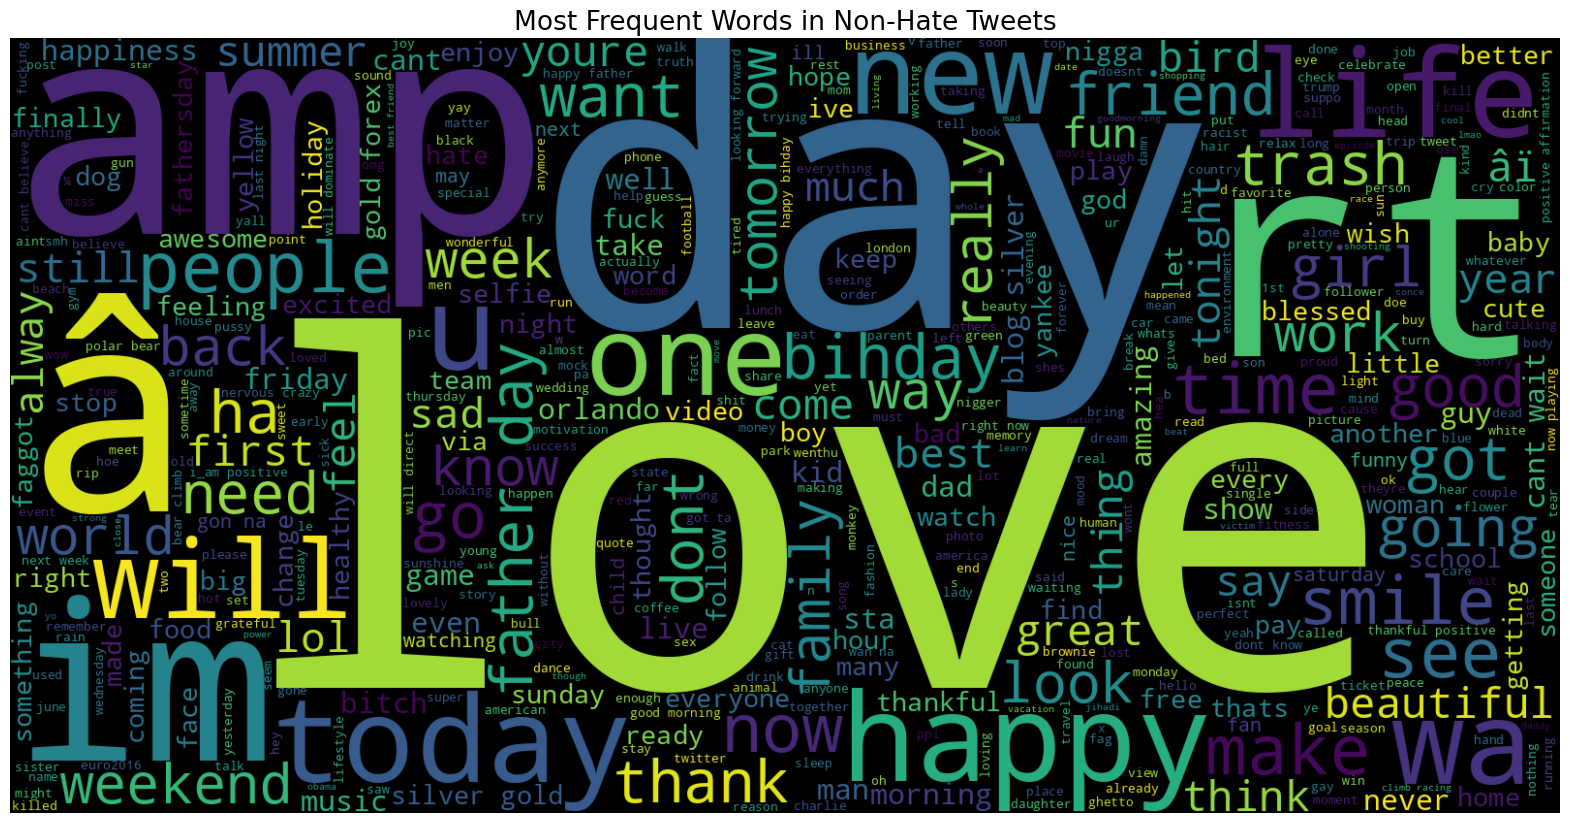

In [14]:

from wordcloud import WordCloud
non_hate_tweets_pd = non_hate_tweets.toPandas()

# Join the text data into a single string
text = ' '.join(non_hate_tweets_pd['tweet'])

# Create the word cloud
plt.figure(figsize=(20, 15), facecolor=None)
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Non-Hate Tweets', fontsize=19)
plt.show()

In [15]:
neg_tweets = tweet_df.filter(tweet_df['class'] == 1)


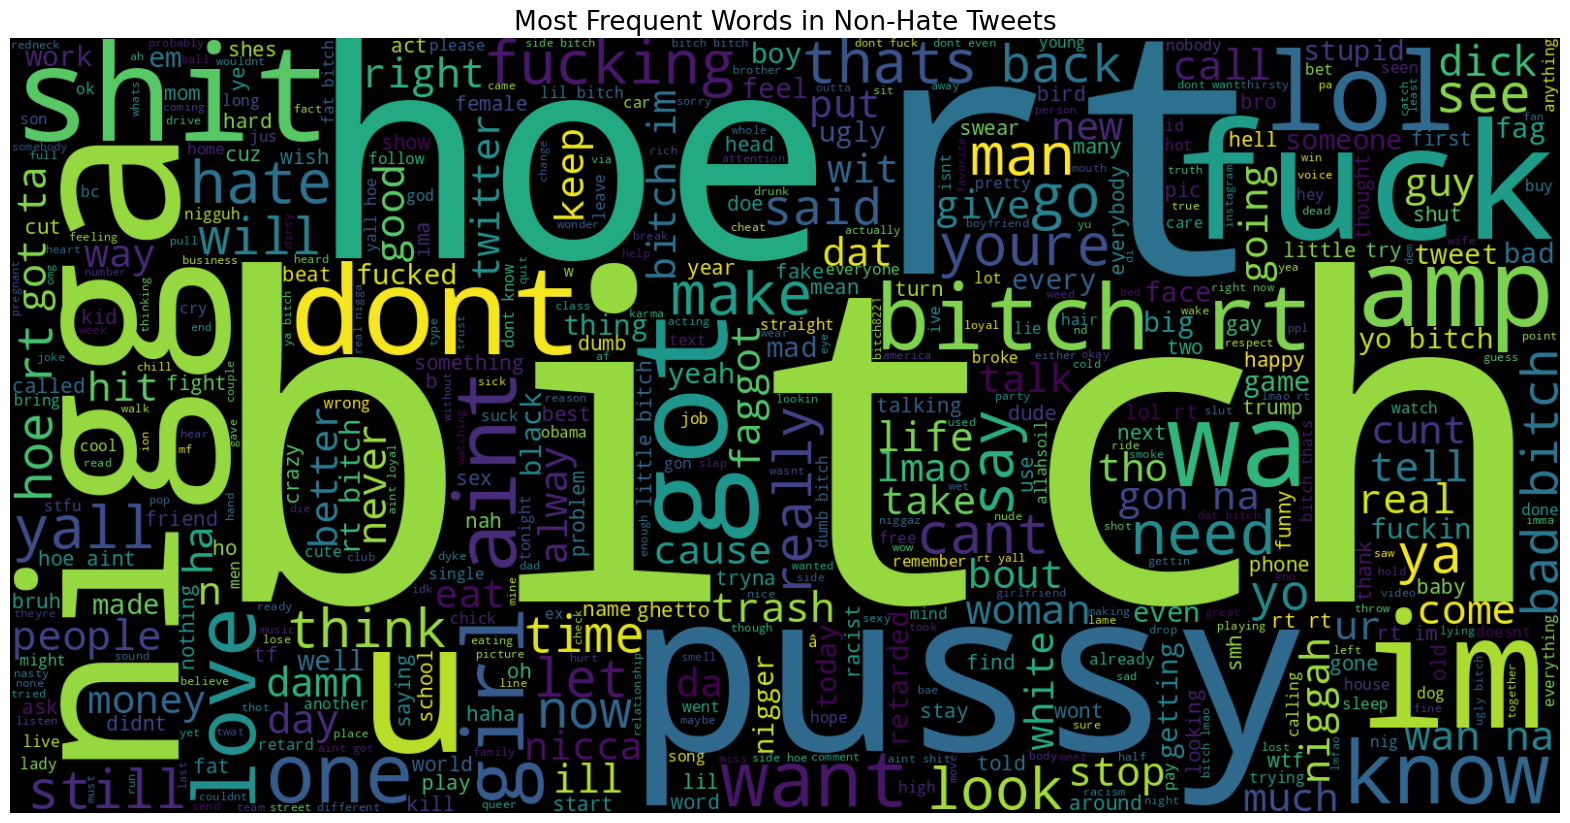

In [16]:

from wordcloud import WordCloud
neg_tweets_pd = neg_tweets.toPandas()

# Join the text data into a single string
text = ' '.join(neg_tweets_pd['tweet'])

# Create the word cloud
plt.figure(figsize=(20, 15), facecolor=None)
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Non-Hate Tweets', fontsize=19)
plt.show()

In [17]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StopWordsRemover

# Step 1: Tokenize the text
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
words_data = tokenizer.transform(tweet_df)

# Step 2: Remove stop words
stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_data = stop_words_remover.transform(words_data)

# Step 3: Use HashingTF to get term frequencies
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=5000)  # Set numFeatures as needed
featurized_data = hashing_tf.transform(filtered_data)

# Step 4: Compute the IDF (Inverse Document Frequency)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
tfidf_data = idf_model.transform(featurized_data)




In [18]:
data = tfidf_data.select("features", "class")

# Step 3: Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Step 4: Separate features and labels for training and testing sets
x_train = train_data.select("features")
y_train = train_data.select("class")

x_test = test_data.select("features")
y_test = test_data.select("class")

# Optional: Show the training and testing sets
x_train.show(truncate=False)
y_train.show(truncate=False)
x_test.show(truncate=False)
y_test.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                             |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(5000,[],[])   

In [19]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F



# Assuming you already have your x_train, y_train, x_test, y_test as DataFrames from the previous steps
# Create DataFrames for training and testing sets
train_data = train_data.withColumnRenamed("class", "label")  # Renaming class to label for PySpark
test_data = test_data.withColumnRenamed("class", "label")

# Step 1: Train the SVM classifier
svm_classifier = LinearSVC(featuresCol='features', labelCol='label')
svm_model = svm_classifier.fit(train_data)

# Step 2: Make predictions
svm_predictions = svm_model.transform(test_data)

# Step 3: Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
svm_acc = evaluator.evaluate(svm_predictions)

print("SVM Test accuracy: {:.2f}%".format(svm_acc * 100))

# Step 4: Generate a confusion matrix
confusion_matrix = svm_predictions.groupBy('label', 'prediction').count().toPandas()
print("SVM Confusion Matrix:\n", confusion_matrix)

# Optional: Display the classification report
# Calculate TP, FP, TN, FN
tp = svm_predictions.filter((F.col("prediction") == 1) & (F.col("label") == 1)).count()
tn = svm_predictions.filter((F.col("prediction") == 0) & (F.col("label") == 0)).count()
fp = svm_predictions.filter((F.col("prediction") == 1) & (F.col("label") == 0)).count()
fn = svm_predictions.filter((F.col("prediction") == 0) & (F.col("label") == 1)).count()

# Calculate precision, recall, and F1-score
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("SVM Classification Report:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")



SVM Test accuracy: 87.84%
SVM Confusion Matrix:
    label  prediction  count
0      1         0.0    688
1      0         1.0    586
2      0         0.0   5701
3      1         1.0   3502
SVM Classification Report:
Precision: 0.86
Recall: 0.84
F1 Score: 0.85


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F


# Assuming you have your train_data and test_data prepared as DataFrames
# Make sure the label column is named 'label'
train_data = train_data.withColumnRenamed("class", "label")  # Rename class to label
test_data = test_data.withColumnRenamed("class", "label")

# Step 1: Train the Random Forest classifier
rf_classifier = RandomForestClassifier(numTrees=900, seed=42, labelCol='label', featuresCol='features')
rf_model = rf_classifier.fit(train_data)

# Step 2: Make predictions
rf_predictions = rf_model.transform(test_data)

# Step 3: Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
rf_acc = evaluator.evaluate(rf_predictions)

print("Random Forest Test accuracy: {:.2f}%".format(rf_acc * 100))

# Optional: Show a confusion matrix
confusion_matrix = rf_predictions.groupBy('label', 'prediction').count().toPandas()
print("Random Forest Confusion Matrix:\n", confusion_matrix)

# Optional: Display the classification report
# Calculate TP, FP, TN, FN
tp = rf_predictions.filter((F.col("prediction") == 1) & (F.col("label") == 1)).count()
tn = rf_predictions.filter((F.col("prediction") == 0) & (F.col("label") == 0)).count()
fp = rf_predictions.filter((F.col("prediction") == 1) & (F.col("label") == 0)).count()
fn = rf_predictions.filter((F.col("prediction") == 0) & (F.col("label") == 1)).count()

# Calculate precision, recall, and F1-score
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("Random Forest Classification Report:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")



In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F



# Assuming you have your train_data and test_data prepared as DataFrames
# Make sure the label column is named 'label'
train_data = train_data.withColumnRenamed("class", "label")  # Rename class to label
test_data = test_data.withColumnRenamed("class", "label")

# Step 1: Train the Naive Bayes classifier
nb_classifier = NaiveBayes(labelCol='label', featuresCol='features')
nb_model = nb_classifier.fit(train_data)

# Step 2: Make predictions
nb_predictions = nb_model.transform(test_data)

# Step 3: Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
nb_acc = evaluator.evaluate(nb_predictions)
print("Naive Bayes Test accuracy: {:.2f}%".format(nb_acc * 100))

# Optional: Show a confusion matrix
confusion_matrix = nb_predictions.groupBy('label', 'prediction').count().toPandas()
print("Naive Bayes Confusion Matrix:\n", confusion_matrix)

# Optional: Display the classification report
# Calculate TP, FP, TN, FN
tp = nb_predictions.filter((F.col("prediction") == 1) & (F.col("label") == 1)).count()
tn = nb_predictions.filter((F.col("prediction") == 0) & (F.col("label") == 0)).count()
fp = nb_predictions.filter((F.col("prediction") == 1) & (F.col("label") == 0)).count()
fn = nb_predictions.filter((F.col("prediction") == 0) & (F.col("label") == 1)).count()

# Calculate precision, recall, and F1-score
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("Naive Bayes Classification Report:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")


